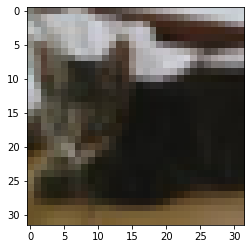

x_train[0].shape:  (32, 32, 3)

Number of training examples: m_train = 50000
Number of testing examples: m_test = 10000
Height/Width of each image: num_px = 32
Each image is of size: (32, 32, 3)
train_set_x shape: (50000, 32, 32, 3)
train_set_y shape: (1, 50000)
test_set_x shape: (10000, 32, 32, 3)
test_set_y shape: (1, 10000)

train_set_x_flatten shape: (3072, 50000)
train_set_y shape: (1, 50000)
test_set_x_flatten shape: (3072, 10000)
test_set_y shape: (1, 10000)
sanity check after reshaping: [59 62 63 43 46]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy
from PIL import Image
from scipy import ndimage
import tensorflow.keras.datasets.cifar10 as cif

%matplotlib inline

# Loading the data (cat/non-cat)
(train_set_x_orig, train_set_y), (test_set_x_orig, test_set_y) = cif.load_data()

for i in range(0, train_set_x_orig.shape[0]):
  if train_set_y[i] == 3:
    train_set_y[i] = 1
  else:
    train_set_y[i] = 0

for i in range(0, test_set_x_orig.shape[0]):
  if test_set_y[i] == 3:
    test_set_y[i] = 1
  else:
    test_set_y[i] = 0

train_set_y = train_set_y.T
test_set_y = test_set_y.T

plt.imshow(train_set_x_orig[9])
plt.show()
print("x_train[0].shape: ", test_set_x_orig[9].shape)
# print("y_train[0]: ", train_set_y[9])
print()

m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print()

# reshape the pic (32, 32, 3) to (32 * 32 * 3, 1)
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

# standerize set
train_set_x = train_set_x_flatten / 255
test_set_x = test_set_x_flatten / 255

### initialize compliete

In [4]:
def sigmoid(z):
  return 1 / (1 + np.exp(-z))

def initialize_with_zeros(dim):
  w = np.zeros((dim, 1))
  b = 0
  assert(w.shape == (dim, 1))
  assert(isinstance(b, float) or isinstance(b, int))
  return w, b

def propagate(w, b, X, Y):
    m = X.shape[1]
    A = sigmoid(np.dot(w.T, X) + b)            # compute activation
    cost = -1 / m * np.sum(Y * np.log(A) + (1 - Y) * np.log(1 - A))         # compute cost

    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = 1 / m * np.dot(X, (A - Y).T)
    db = 1 / m * np.sum(A - Y)

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost
  
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    costs = []
    
    for i in range(num_iterations):
        # Cost and gradient calculation
        grads, cost = propagate(w, b, X, Y)

        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule (≈ 2 lines of code)\
        w = w - learning_rate * dw
        b = b - learning_rate * db
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training examples
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

def predict(w, b, X):
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    A = sigmoid(np.dot(w.T, X) + b)

    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if A[0, i] <= 0.5:
            Y_prediction[0, i] = 0
        else:
            Y_prediction[0, i] = 1
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    # initialize parameters with zeros
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]

    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.01, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.318622
Cost after iteration 200: 0.313725
Cost after iteration 300: 0.310542
Cost after iteration 400: 0.308238
Cost after iteration 500: 0.306490
Cost after iteration 600: 0.305122
Cost after iteration 700: 0.304022
Cost after iteration 800: 0.303119
Cost after iteration 900: 0.302365
Cost after iteration 1000: 0.301724
Cost after iteration 1100: 0.301172
Cost after iteration 1200: 0.300689
Cost after iteration 1300: 0.300263
Cost after iteration 1400: 0.299883
Cost after iteration 1500: 0.299539
Cost after iteration 1600: 0.299226
Cost after iteration 1700: 0.298939
Cost after iteration 1800: 0.298674
Cost after iteration 1900: 0.298427
train accuracy: 89.9 %
test accuracy: 89.87 %


y = 1
pridict: non cat

y = 0
pridict: non cat

y = 0
pridict: non cat

y = 0
pridict: non cat

y = 0
pridict: non cat

y = 0
pridict: non cat

y = 0
pridict: cat

y = 0
pridict: non cat

y = 1
pridict: non cat

y = 0
pridict: non cat

y = 0
pridict: non cat

y = 0
pridict: non cat

y = 0
pridict: non cat

y = 0
pridict: non cat

y = 0
pridict: non cat

y = 0
pridict: non cat

y = 0
pridict: non cat

y = 0
pridict: non cat

y = 0
pridict: non cat

y = 0
pridict: non cat



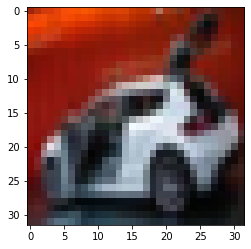

In [14]:
for index in range(0, 20):
  print ("y = " + str(test_set_y[0,index]))
  if int(d["Y_prediction_test"][0,index]) == 1:
    plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)))
    print ("pridict: cat")
  else:
    print ("pridict: non cat")
  print()